# Project

## Introduction to the Project
The S&P 500 (Standard & Poor's 500) is a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. It is widely regarded as one of the best representations of the U.S. stock market and economy. Over the long term, the S&P 500 has shown consistent growth, making it a key focus for long-term investors. However, it can also experience significant volatility in the short term.

In this project, we will make our first attempt to build a momentum-based strategy to trade the S&P 500 index. At the end of the project, you will have built a program that you can later expand and customise to suit your needs. We will use the python packages numpy, scipy and sqlite3, among others, in this project.

Tips: Review the code snippets that we went through during the course. Reorganize them and you are half-way done! Try experimenting with different configurations of the confidence interval, the lookback window and the forecast horizon. Be brave and experiment with different ways of deciding the position size. You may be surprised by your talent!

Re-organize your code from the exercises into a Python program that 
1. read prices from a database
2. calibrate a GBM model on each day when new prices are received.
3. forecast the price in e.g. 10 days and
   1. calculate the confidence interval of the forecast
   2. calculate the expected shortfall from the price forecast
4. code your trading signals using the price forecast and the expected shortfall.
5. store your postions into the *positions* table after each trade.
6. produce a 1-year backtest record from 2020-06-01 to 2021-05-31.

**Hint**

1. Collect all the code related to the GBM model into a class

In [1]:
import csv
import sqlite3
from contextlib import closing
from datetime import datetime

import numpy as np
from scipy.stats import norm

conn = sqlite3.connect("SP500.db")
cs = conn.cursor()


In [2]:
class GBM:
    def __init__(self):
        # TODO: Replace the following with your code
        #self.mu, self.sigma = [np.nan] * 2
        self.mu = np.nan;
        self.sigma = np.nan;
        self.rng = np.random.default_rng()
        
    def simulate(self, N, K, Dt, S0):
        traj = np.full((N+1, K), np.nan)
        
        sqrt_Dt = 1/np.sqrt(N)
        
        drift = (self.mu - self.sigma**2/2) * np.linspace(1, N, N) * Dt
        for i in range(K):
            W = sqrt_Dt * np.cumsum(norm.rvs(size=N))
            traj[1:, i] = S0 * np.exp(drift + self.sigma * W)
            traj[0, i] = S0
        
        return traj

    def calibrate(self, trajectory, Dt):
        increments = np.diff(np.log(trajectory));
        moments = [0, 0];
        n_iter = 10;
        for iter in range(n_iter):
            X = self.rng.choice(increments, size=len(increments)//2)
            moments[0] += np.mean(X)/n_iter;
            moments[1] += np.mean(X**2)/n_iter
        std = np.sqrt(moments[1] - moments[0]**2);
        self.sigma = std/np.sqrt(Dt);
        self.mu = moments[0] / Dt + self.sigma**2/2;
        
    def forecast(self, latest, dT, confidence):
        forecast = (latest * np.exp(self.mu * dT))
        print(F"Price forecast: {forecast}")
        
        Q = norm.ppf([(1-confidence)/2, (1 + confidence)/2],
             loc=(self.mu - self.sigma**2/2)*dT,
             scale=model.sigma*np.sqrt(dT))
        confidence_interval = latest * np.exp(Q)
        print(F"Confidence Intervals: % .4f,  % .4f" % (confidence_interval[0], confidence_interval[1]))
        return {
            'confidence' : confidence,
            'expected' : forecast,
            'interval' : confidence_interval
        }
        
    def expected_shortfall(self, T, confidence):
        m = (self.mu - self.sigma**2/2) * T
        s = self.sigma * np.sqrt(T)

        alpha = 0.95
        ES = -m + s * norm.pdf(norm.ppf(confidence))/(1 - confidence)
        print(F"The 95% expected shortfall is {ES}")
        return ES


In [3]:
# test your code here
model = GBM()
model.mu = 0.3
model.sigma = 0.2
simulated = model.simulate(500, 1, 1/250, 100)
simulated = simulated[:, 0]

model2 = GBM()
model2.calibrate(simulated, 1/250)

print(F"Calibrated: mu = {model2.mu}, sigma = {model2.sigma}")



Calibrated: mu = 0.13859198413039397, sigma = 0.13989159699867085


2. Write a function that prepares the database for trading, i.e.
   1. load the historical prices into the *prices* table
   2. create the *positions* table
   3. initialize the *positions* table with the your initial cash reserve. The initial *time_of_trade* can be any date before the earliest possible trading date.

    Call this function *prepare*.

In [4]:
def prepare():
    # load the hitorical data into new prices table
    
    cs.execute("""
    create table if not exists prices (
    theday text primary key,
    price real
    );
    """)
    
    with closing(open('SP500.csv')) as datafile:
        reader = csv.DictReader(datafile, fieldnames=["date", "price"], delimiter='\t')
        
        for row in reader:
            cs.execute(F"insert or ignore into prices values (\"{row['date']}\", {float(row['price'])})")
    conn.commit()
    
    cs.execute(F"""
    create table if not exists positions (
    time_of_trade text,
    instrument text,
    quantity real,
    cash real,
    primary key (time_of_trade, instrument)
    );
    """);
    cs.execute(F"""
        insert or ignore into positions values
        ('1666-01-01', 'SP500', 0, 1000000);
        """)
    conn.commit()

In [5]:
# check whether you have loaded the prices correctly
prepare()
latest_prices = cs.execute("select * from prices order by theday desc limit 10")
for item in latest_prices:
    print(item)

('2021-05-31', 4203.60009765625)
('2021-05-30', 4210.10009765625)
('2021-05-28', 4206.0)
('2021-05-27', 4217.10009765625)
('2021-05-26', 4196.0)
('2021-05-25', 4197.5)
('2021-05-24', 4204.7001953125)
('2021-05-23', 4153.2998046875)
('2021-05-21', 4161.39990234375)
('2021-05-20', 4165.5)


3. Write a function that determines the trade size, i.e. how many units of the instrument you would like to own when the date is *which_day* and the price forecast of the instrument is *forecast* and the expected shortfall from the same forecast is *ES*.

In [6]:
def position_size(which_day, forecast, ES):
    
    cs.execute(F"""
    select quantity, cash from positions
    where instrument = 'SP500'
    and time_of_trade < '{which_day}'
    order by time_of_trade desc
    limit 1;
    """)
    qty, cash = cs.fetchall()[0]
    cs.execute(F"""
    select price from prices
    where theday <= '{which_day}'
    order by theday desc
    limit 1;
    """);
    price = cs.fetchall()[0][0]
    capital = cash + qty * price
    #print ("capital = " + str(capital))
    
    exposure = capital * 0.05 / ES
    if price < forecast['interval'][0]:
        return round(exposure/price)
    elif price > forecast['interval'][1]:
        return -round(exposure/price)
    else:
        return 0


In [7]:
#exposure =1000000.0 * 0.05/0.0422898410992397
#print (exposure)

4. Write a function that, for a given date, calibrates a GBM model to the data prior to that date and that forecasts the price in 10 days. Call this function *analyse*.

In [8]:
def analyse(which_day):
    cs.execute(F"""
    select price from prices where theday <='{which_day}'
    order by theday desc limit 120;
    """)
    P = np.flipud(np.asarray(cs.fetchall())).flatten();
    model= GBM()
    Dt = 1.0/252
    model.calibrate (P, Dt)
    T= 10 * Dt
    forecast = model.forecast (P[-1], T, 0.1)
    ES = model.expected_shortfall(T, 0.95)
    
    return position_size ( which_day, forecast, ES)
    


In [9]:
# Test the analyse function
test_dates = ['2021-05-09', '2021-05-14']
positions = [np.nan, np.nan]
for i in range(2):
    positions[i] = analyse(test_dates[i])
    print(F"{positions[i]} shares advised on {test_dates[i]}.")

Price forecast: 4278.735831483469
Confidence Intervals:  4255.9512,   4298.7798
The 95% expected shortfall is 0.044293427356934735
328 shares advised on 2021-05-09.
Price forecast: 4233.278317337841
Confidence Intervals:  4210.5621,   4252.9340
The 95% expected shortfall is 0.043890166684450324
331 shares advised on 2021-05-14.


5. The main loop of the program: Loop over the dates in the backtest period and use the *analyse* function to decide what to do on each day. Call this function *main*.

In [10]:
def main(begin_on):
    cs.execute(F"select theday from prices where theday >= '{begin_on}';")
    days = [d[0] for d in cs.fetchall()]
    asset = {
        'old': np.nan,
        'new': np.nan
    };
    cash = {
        'old': np.nan,
        'new': np.nan
    };
    cs.execute("delete from positions where time_of_trade > '2020-01-01';");
    for d in days:
        asset['new'] = analyse(d)
        cs.execute(F"""
        select quantity, cash from positions
        where time_of_trade < '{d}'
        order by time_of_trade desc
        limit 1;
        """);
        asset['old'], cash['old'] = cs.fetchall()[0];
        cs.execute(F"""
        select price from prices
        where theday <= '{d}'
        order by theday desc
        limit 1;
        """);
        latest = cs.fetchall()[0][0]
        trade_size = round(asset['new']) - round(asset['old']);
        if trade_size != 0:
            cash['new'] = cash['old'] - trade_size * latest;
            cs.execute(F"""
            insert into positions values
            ('{d}', 'SP500', {round(asset['new'])}, {cash['new']});
            """);
        conn.commit();



6. Connect to the database and create a *cursor* object associated with the connection. Share the connection and the cursor object across the program so that you don't have to connect to and disconnect from the database in every function of the program.

In [11]:
if __name__ == "__main__":
    with closing(sqlite3.connect("SP500.db")) as conn:
        with closing(conn.cursor()) as cs:
            prepare()
            main('2020-06-01')
    


Price forecast: 3069.1168299423866
Confidence Intervals:  3043.5422,   3074.1701
The 95% expected shortfall is 0.16334942577588818
Price forecast: 3056.85724685868
Confidence Intervals:  3032.2696,   3062.7840
The 95% expected shortfall is 0.175179129633794
Price forecast: 3131.75130087407
Confidence Intervals:  3106.0621,   3137.3191
The 95% expected shortfall is 0.16692947819236906
Price forecast: 3049.303862017331
Confidence Intervals:  3023.7310,   3054.1595
The 95% expected shortfall is 0.19382879149590598
Price forecast: 3168.5507337481754
Confidence Intervals:  3142.6091,   3174.2339
The 95% expected shortfall is 0.1747862046859435
Price forecast: 3220.5245653292372
Confidence Intervals:  3193.4504,   3225.5868
The 95% expected shortfall is 0.17130762015616796
Price forecast: 3273.821596419061
Confidence Intervals:  3246.4870,   3279.1572
The 95% expected shortfall is 0.15792920697754959
Price forecast: 3163.388675283801
Confidence Intervals:  3137.3944,   3168.9668
The 95% expe

Price forecast: 3509.677045785318
Confidence Intervals:  3488.7117,   3523.8194
The 95% expected shortfall is 0.06111471200340629
Price forecast: 3536.6778430666604
Confidence Intervals:  3515.4423,   3550.8190
The 95% expected shortfall is 0.06532216830244142
Price forecast: 3515.6006337988897
Confidence Intervals:  3494.4576,   3529.6231
The 95% expected shortfall is 0.07515363143111438
Price forecast: 3501.4357734685527
Confidence Intervals:  3480.9087,   3515.9379
The 95% expected shortfall is 0.0811089284697952
Price forecast: 3560.5535084137528
Confidence Intervals:  3539.6964,   3575.3172
The 95% expected shortfall is 0.06822967941970616
Price forecast: 3563.693966977942
Confidence Intervals:  3543.2631,   3578.9198
The 95% expected shortfall is 0.06482478907817968
Price forecast: 3593.1378614373807
Confidence Intervals:  3572.3682,   3608.3178
The 95% expected shortfall is 0.06264978340521543
Price forecast: 3561.797318435319
Confidence Intervals:  3541.0940,   3576.7288
The 95

Price forecast: 3719.7545433964806
Confidence Intervals:  3699.3292,   3736.5564
The 95% expected shortfall is 0.045408772481779755
Price forecast: 3666.8938287929564
Confidence Intervals:  3646.6021,   3683.2987
The 95% expected shortfall is 0.06160329479524581
Price forecast: 3698.4686394643086
Confidence Intervals:  3678.0393,   3715.0523
The 95% expected shortfall is 0.05764207080922838
Price forecast: 3736.3835223211363
Confidence Intervals:  3715.6920,   3753.0838
The 95% expected shortfall is 0.05047793448330393
Price forecast: 3710.004167199927
Confidence Intervals:  3689.4037,   3726.5310
The 95% expected shortfall is 0.05920963007715346
Price forecast: 3767.1676887348945
Confidence Intervals:  3746.5950,   3784.2979
The 95% expected shortfall is 0.0434436542525973
Price forecast: 3746.64005513916
Confidence Intervals:  3725.9910,   3763.4865
The 95% expected shortfall is 0.05465794794097985
Price forecast: 3742.3741126212444
Confidence Intervals:  3721.8117,   3759.2652
The 9

Price forecast: 4020.0473074415986
Confidence Intervals:  3998.1762,   4038.4107
The 95% expected shortfall is 0.04836617288504453
Price forecast: 4038.5864914294066
Confidence Intervals:  4016.7610,   4057.1826
The 95% expected shortfall is 0.046447899150201005
Price forecast: 3957.115603383291
Confidence Intervals:  3935.5802,   3975.1849
The 95% expected shortfall is 0.05361158065451524
Price forecast: 3965.121145720524
Confidence Intervals:  3943.6655,   3983.3515
The 95% expected shortfall is 0.045950020744607245
Price forecast: 3965.1628388479326
Confidence Intervals:  3943.8142,   3983.5017
The 95% expected shortfall is 0.04389198520416247
Price forecast: 3995.423470871354
Confidence Intervals:  3973.7080,   4013.6963
The 95% expected shortfall is 0.05028713090400739
Price forecast: 3941.4699329298137
Confidence Intervals:  3920.0610,   3959.5095
The 95% expected shortfall is 0.05392430849355285
Price forecast: 3955.836440640483
Confidence Intervals:  3934.6750,   3974.2706
The 

In [12]:
# plot your track record
conn = sqlite3.connect("SP500.db")
cs = conn.cursor()

day1 = '2020-06-01'
day1_dt = datetime.strptime(day1, '%Y-%m-%d')

cs.execute(f"""
    select theday, quantity * price + cash as wealth
    from positions as PO
    join prices as PR
    on PO.time_of_trade = (
        select time_of_trade from positions
        where time_of_trade <= PR.theday
        order by time_of_trade desc limit 1
    )
    where theday >= '{day1}';
""")

records = cs.fetchall()

def calculate_T(record, day1_dt):
    theday, wealth = record
    theday_dt = datetime.strptime(theday, '%Y-%m-%d')
    T = (theday_dt - day1_dt).days
    return (T, wealth)

records = [calculate_T(record, day1_dt) for record in records]
W = np.asarray(records)

In [13]:
import matplotlib.pyplot as plt

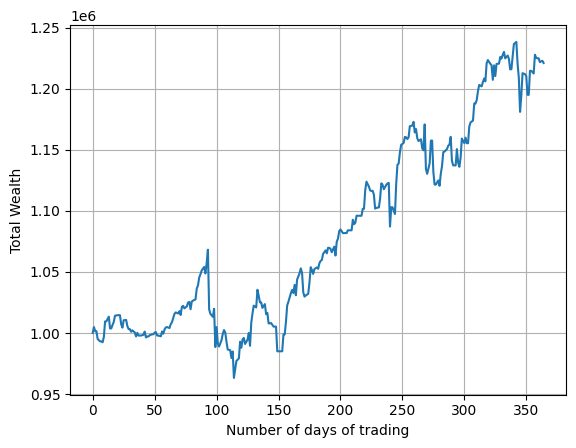

In [14]:
fig = plt.plot(W[:,0], W[:, 1])
plt.grid()
plt.xlabel("Number of days of trading")
plt.ylabel('Total Wealth');